## **Author**
The code was written by Abdullah Olcay (University of Southampton). If you want to copy or share the code, please refer to me!

For more information contact me: olcayazzam@gmail.com

### **Autoencoders for Denoising**
In this section, we handle with how to denoise a signal by using autoencoders. 
Autoencoders are used for different purposes, one is to remove noise introduced a signal. 
Basically, we feed our neural network model with a noisy signal and we expect/target a denoised signal. 
Autoencoder, for that, first learn an encoded state based on a noise data and decode it to yield a signal without noise. 
In essence, autoencoder will learn the noisy signal in ecoder part to recognize/identify what is the noise in signal and remove it from the input (noisy) data through decoder part.

#### **Prepare Data**
In this example, we used an eeg signal that was also given in the repository I shared `LMS-Adaptive-Filter`([click here](https://github.com/aaolcay/LMS-Adaptive-Filter)). This is 1 dimensional data, so we used `Conv1D` and `Conv1DTranspose` in autoencoder for denoising process.

We have already filtered the noise out by using a high-pass filter with 0.7 Hz cut-off. We, in this example, need both noisy signal (features/input) and its noise removed version (target).

However, be careful, we have one noisy and its denoised version. This shows we have lack of data to train our autoencoder model. It is also possible to use only one data (you can try, it will be likely to denoise the signal as dependent on number of epochs). Therefore, we augmanted the data (both noisy and denoised) by reproducing 100 times.

In [43]:
# Load data that are mat files
import scipy.io
noisy_signal = scipy.io.loadmat('eeg_signal.mat')
denoised_signal = scipy.io.loadmat('eeg_signal_denoised.mat')
noisy_signal = noisy_signal['x']
denoised_signal = denoised_signal['desired_signal']

In [44]:
print(f"Types of both data are: \n{type(noisy_signal)}\n{type(denoised_signal)}")
print(f"And their shapes are:\n{noisy_signal.shape}\n{denoised_signal.shape}")

Types of both data are: 
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
And their shapes are:
(1, 592422)
(1, 592422)


We will just reshape our data to make it suitable for input shape of 1D convolutional layer used in autoencoder model.

(1, 592422) -> (592422, 1)

In [45]:
noisy_signal = noisy_signal.reshape(-1,1)
denoised_signal = denoised_signal.reshape(-1,1)
print(f"Shapes of data after reshape applied:\n{noisy_signal.shape}\n{denoised_signal.shape}")

Shapes of data after reshape applied:
(592422, 1)
(592422, 1)


As seen both data types are numpy arrays that is what really we want... 

However, we have only one noisy data and its denoised version as mentioned in advance. Hence, we copied both data 100 times.

In [46]:
import numpy as np
noisy_signal = np.repeat(noisy_signal[np.newaxis,...], 100, axis=0)
denoised_signal = np.repeat(denoised_signal[np.newaxis,...], 100, axis=0)
print(f"Shapes of data after repeat applied:\n{noisy_signal.shape}\n{denoised_signal.shape}")

Shapes of data after repeat applied:
(100, 592422, 1)
(100, 592422, 1)


Let's plot first 10 data, note that all of them overlap

Text(0.5, 0, 'samples')

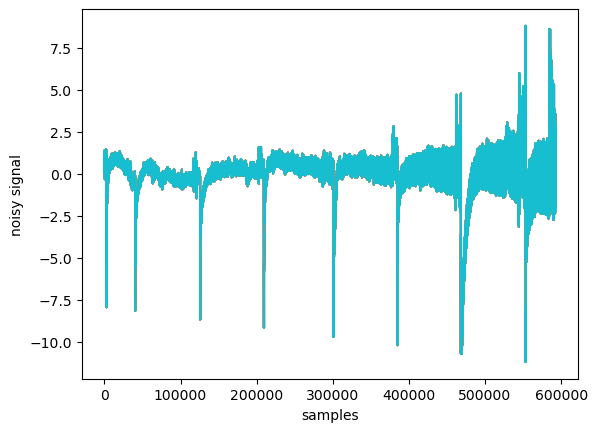

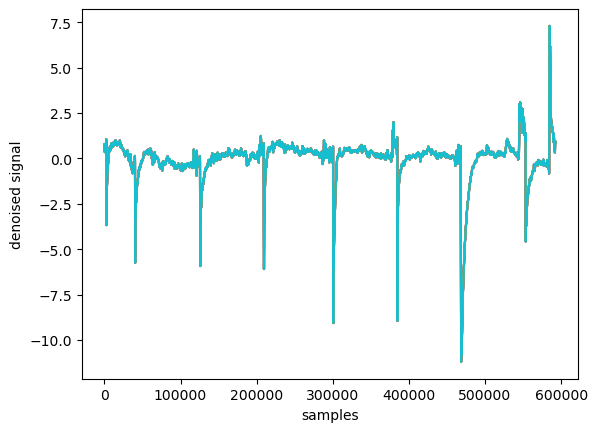

In [47]:
import matplotlib.pyplot as plt
plt.figure()
for i in range(10):
  plt.plot(noisy_signal[i])
plt.ylabel('noisy signal')
plt.xlabel('samples')

plt.figure()
for i in range(10):
  plt.plot(denoised_signal[i])
plt.ylabel('denoised signal')
plt.xlabel('samples')

For the memory, and not to crash your computer, we restricted the signals from 460000 to 480000 samples.

Shapes of data after repeat applied:
(100, 40000, 1)
(100, 40000, 1)


Text(0, 0.5, 'denoised signal')

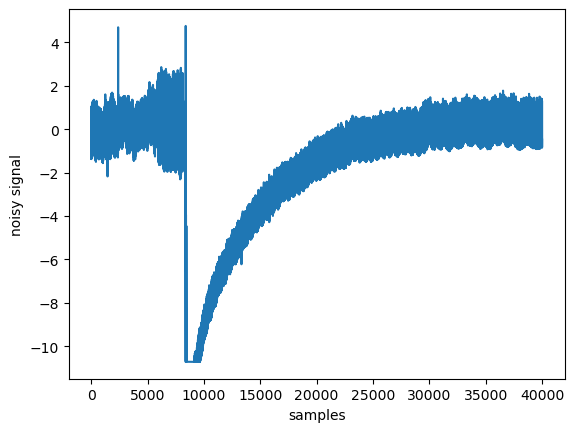

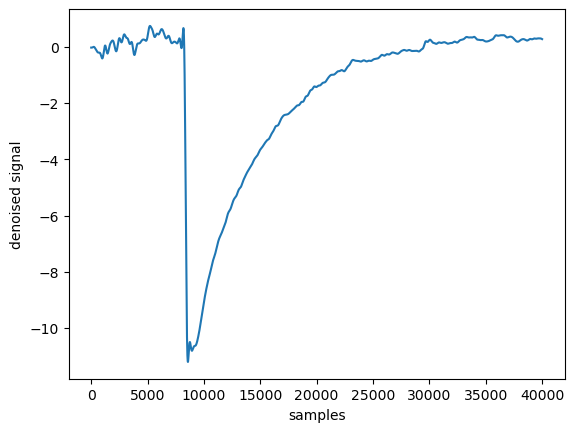

In [48]:
test_data = noisy_signal
noisy_signal = noisy_signal[:,460000:500000,:]
denoised_signal = denoised_signal[:,460000:500000,:]
print(f"Shapes of data after repeat applied:\n{noisy_signal.shape}\n{denoised_signal.shape}")
plt.figure()
plt.plot(noisy_signal[0])
plt.xlabel('samples')
plt.ylabel('noisy signal')

plt.figure()
plt.plot(denoised_signal[0])
plt.xlabel('samples')
plt.ylabel('denoised signal')

#### **Build Autoencoder Model by using TensorFlow Keras Sequential**


In [49]:
# Model Configuration
input_shape = (noisy_signal.shape[1],noisy_signal.shape[2])
batch_size = 32
num_epochs = 5 # relatively small value as our data have very large number of samples
max_norm_value = 2.0 # this is default value for max_norm in kernel_constraint 
                     # and forces weights to have a magnitude at or below this given limit 
                     # so that excessively high weights do not cause overfitting in the model

##### **Encoder**
Encoder part consists of two 1D convolutional layers with batch normalization.

In [50]:
import tensorflow.keras as keras

autoencoder = keras.Sequential()

# Encoder Part
autoencoder.add(keras.layers.Conv1D(filters=128,
                                    kernel_size=3,
                                    activation='relu',
                                    input_shape=input_shape))
autoencoder.add(keras.layers.BatchNormalization())

autoencoder.add(keras.layers.Conv1D(filters=64,
                                    kernel_size=3,
                                    activation='relu',
                                    input_shape=input_shape))
autoencoder.add(keras.layers.BatchNormalization())
                                  

In [51]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 39998, 128)        512       
                                                                 
 batch_normalization_4 (Batc  (None, 39998, 128)       512       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 39996, 64)         24640     
                                                                 
 batch_normalization_5 (Batc  (None, 39996, 64)        256       
 hNormalization)                                                 
                                                                 
Total params: 25,920
Trainable params: 25,536
Non-trainable params: 384
_________________________________________________________________


##### **Decoder**
Mirror of encoder.

In [52]:
autoencoder.add(keras.layers.Conv1DTranspose(filters=64,
                                    kernel_size=3,
                                    activation='relu'))
autoencoder.add(keras.layers.BatchNormalization())

autoencoder.add(keras.layers.Conv1DTranspose(filters=128,
                                    kernel_size=3,
                                    activation='relu',
                                    input_shape=input_shape))
autoencoder.add(keras.layers.BatchNormalization())

In [53]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 39998, 128)        512       
                                                                 
 batch_normalization_4 (Batc  (None, 39998, 128)       512       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 39996, 64)         24640     
                                                                 
 batch_normalization_5 (Batc  (None, 39996, 64)        256       
 hNormalization)                                                 
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 39998, 64)        12352     
 ranspose)                                                       
                                                      

In [54]:
# autoencoder's output
autoencoder.add(keras.layers.Conv1D(filters=1,
                                    kernel_size=3,
                                    activation='sigmoid',
                                    padding='same'))

In [55]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 39998, 128)        512       
                                                                 
 batch_normalization_4 (Batc  (None, 39998, 128)       512       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, 39996, 64)         24640     
                                                                 
 batch_normalization_5 (Batc  (None, 39996, 64)        256       
 hNormalization)                                                 
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 39998, 64)        12352     
 ranspose)                                                       
                                                      

##### **Compile and Train Data**


In [56]:
# Compiling network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [57]:
# Train/Fit network
autoencoder.fit(noisy_signal,
                denoised_signal,
                epochs=num_epochs,
                batch_size=batch_size,
                validation_split=0.2)

Epoch 1/5
3/3 [==============================] - 94s 24s/step - loss: 1.1596 - val_loss: 0.6939
Epoch 2/5
3/3 [==============================] - 78s 22s/step - loss: -1.5123 - val_loss: 0.5261
Epoch 3/5
3/3 [==============================] - 71s 21s/step - loss: -3.3294 - val_loss: 0.3456
Epoch 4/5
3/3 [==============================] - 67s 20s/step - loss: -4.7948 - val_loss: 0.1530
Epoch 5/5
3/3 [==============================] - 58s 17s/step - loss: -6.0382 - val_loss: -0.0461


After training our model, we will now enter a test data that is the signal's part between 150000 and 300000 samples, and visuailize the result.

1/1 [==============================] - 0s 214ms/step


Text(0, 0.5, 'denoised signal (by autoencoder)')

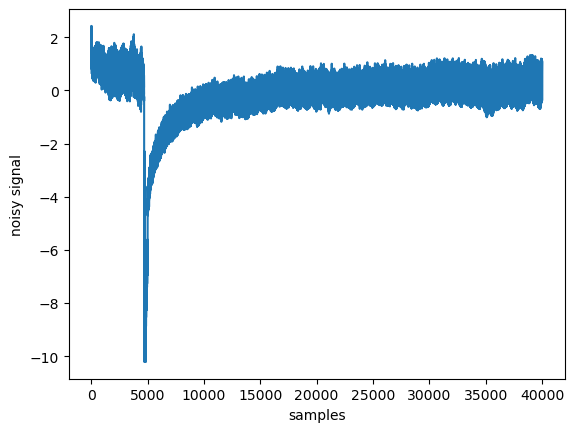

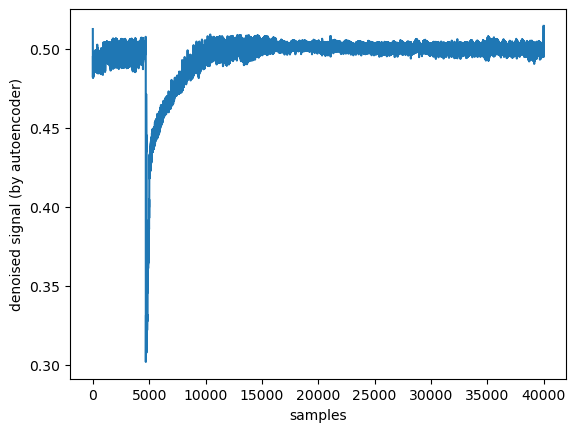

In [59]:
test = test_data[1:2,380000:420000,:]
prediction = autoencoder.predict(test)

plt.figure()
plt.plot(test[0])
plt.xlabel('samples')
plt.ylabel('noisy signal')

plt.figure()
plt.plot(prediction[0])
plt.xlabel('samples')
plt.ylabel('denoised signal (by autoencoder)')